# Check topic diversity of recommendations

## Global settings and imports

In [173]:
import tensorflow.keras

In [174]:
import sys
import os
import numpy as np
import zipfile
from tqdm import tqdm
import scrapbook as sb
from tempfile import TemporaryDirectory
import tensorflow as tf
# tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.models.deeprec.deeprec_utils import download_deeprec_resources 
from recommenders.models.newsrec.newsrec_utils import prepare_hparams
from recommenders.models.newsrec.models.npa import NPAModel
from recommenders.models.newsrec.io.mind_iterator import MINDIterator
from recommenders.models.newsrec.newsrec_utils import get_mind_data_set

print("System version: {}".format(sys.version))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.9.12 (main, Jun  1 2022, 11:38:51) 
[GCC 7.5.0]
Tensorflow version: 2.15.0


## Download and load data

In [175]:
tmpdir = TemporaryDirectory()
data_path = tmpdir.name

train_news_file = os.path.join(data_path, 'train', r'news.tsv')
train_behaviors_file = os.path.join(data_path, 'train', r'behaviors.tsv')
valid_news_file = os.path.join(data_path, 'valid', r'news.tsv')
valid_behaviors_file = os.path.join(data_path, 'valid', r'behaviors.tsv')
wordEmb_file = os.path.join(data_path, "utils", "embedding.npy")
userDict_file = os.path.join(data_path, "utils", "uid2index.pkl")
wordDict_file = os.path.join(data_path, "utils", "word_dict.pkl")
yaml_file = os.path.join(data_path, "utils", r'npa.yaml')


MIND_type='demo'
mind_url, mind_train_dataset, mind_dev_dataset, mind_utils = get_mind_data_set(MIND_type)

if not os.path.exists(train_news_file):
    download_deeprec_resources(mind_url, os.path.join(data_path, 'train'), mind_train_dataset)
    
if not os.path.exists(valid_news_file):
    download_deeprec_resources(mind_url, \
                               os.path.join(data_path, 'valid'), mind_dev_dataset)
if not os.path.exists(yaml_file):
    download_deeprec_resources(r'https://recodatasets.z20.web.core.windows.net/newsrec/', \
                               os.path.join(data_path, 'utils'), mind_utils)
    
    

100%|██████████| 17.0k/17.0k [00:00<00:00, 41.8kKB/s]
100%|██████████| 9.84k/9.84k [00:00<00:00, 28.5kKB/s]
100%|██████████| 95.0k/95.0k [00:01<00:00, 67.5kKB/s]


In [206]:
import pandas as pd

n_cols = ['newsid', 'category', 'subcategory', 'news title', 'news abstract', 'news url', 'entities in news title', 'entities in news abstract']
b_cols = ['impression_id', 'user_id', 'impression_time', 'user_click_history', 'impression_news']

# Load the TSV file with specified column names
df_news = pd.read_csv(valid_news_file, delimiter='\t', names=n_cols)
df_behaviors = pd.read_csv(valid_behaviors_file, delimiter='\t', names=b_cols)

print(len(df_news))
print(len(df_behaviors))

18723
7538


In [177]:
# Read the file
import json

file_path = 'prediction.txt'

# Function to read and parse the prediction.txt file
def parse_predictions(file_path):
    predictions = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(' ')
            impression_id = parts[0]
            ranks = json.loads('[' + parts[1] + ']')
            predictions[impression_id] = ranks
    return predictions

predictions = parse_predictions(file_path)


# Map news recommendation rankings to news articles

In [204]:
import pandas as pd

# Function to get news names and categories based on rankings
def get_news_and_categories(df, predictions):
    results = {}
    for key, rankings in predictions.items():   
        news_items = df.loc[int(key)-1, 'impression_news'].split()  # Adjust if necessary
#         categories = df.loc[key, 'categories']  # Adjust if necessary
        ranked_news = [news_items[i-1] for i in rankings[0]]  # Map rankings to news IDs
#         ranked_categories = [categories[i] for i in rankings]  # Map rankings to categories
        results[key] = ranked_news


    return results

# Example usage
results = get_news_and_categories(df_behaviors, predictions)

def parse_news_ids(news_ids):
    # Remove trailing '-0' or '-1' from each string in the list
    parsed_ids = [news_id[:-2] if news_id.endswith(('-0', '-1')) else news_id for news_id in news_ids]
    return parsed_ids


parsed_results = {key: parse_news_ids(value) for key, value in results.items()}
print(len(parsed_results))
print(len(df_news))

7538
18723


In [202]:
print(news_id)
news_row = df_news[df_news['newsid'] == news_id]
news_row

N8620-1


,newsid,category,subcategory,news title,news abstract,news url,entities in news title,entities in news abstract


## Map news articles to categories and subcategories

In [209]:
from tqdm import tqdm

category_mapping = {}

# Iterate through the results dictionary
for result_id, news_ids in tqdm(results.items()):
    news_ids = parse_news_ids(news_ids)
    for news_id in news_ids:
        # Find the row in df_news where the news_id matches

        news_row = df_news[df_news['newsid'] == news_id]
        
        # Extract the category and subcategory from the row
        category = news_row['category'].values[0]
        subcategory = news_row['subcategory'].values[0]
        
        # If the category is not already in the mapping, add it with an empty list
        if category not in category_mapping:
            category_mapping[category] = {'subcategories': {}, 'news_ids': []}
        
        # If the subcategory is not already in the subcategories mapping, add it with an empty list
        if subcategory not in category_mapping[category]['subcategories']:
            category_mapping[category]['subcategories'][subcategory] = []
        
        # Add the news_id to the category and subcategory mapping
        category_mapping[category]['news_ids'].append(news_id)
        category_mapping[category]['subcategories'][subcategory].append(news_id)

# Print the category mapping
print(category_mapping)

100%|██████████| 7538/7538 [06:15<00:00, 20.08it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




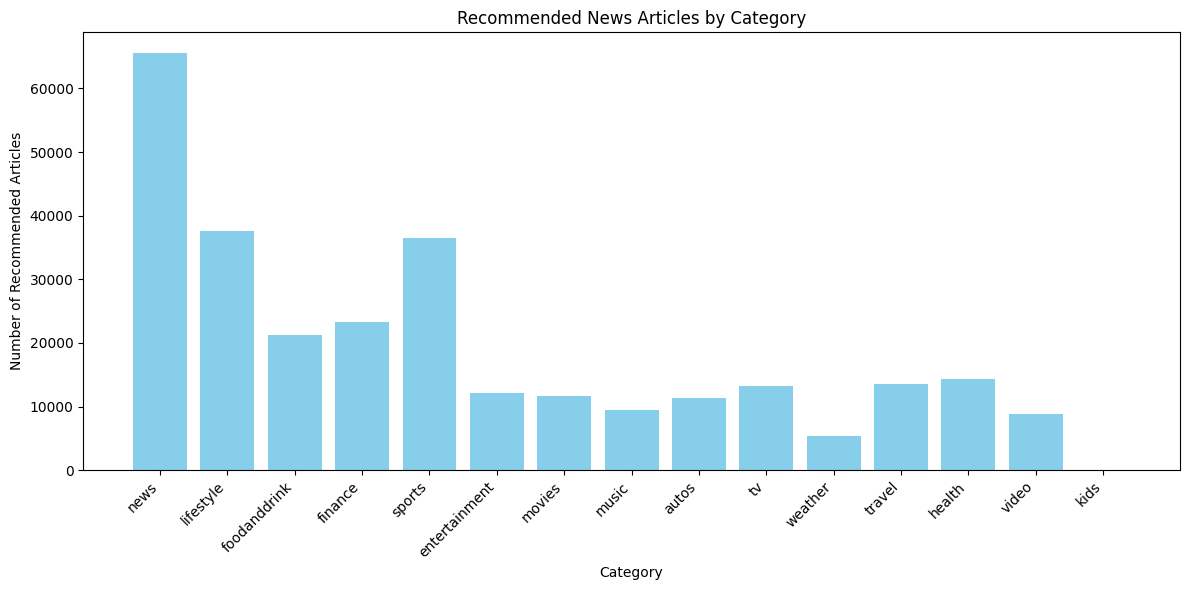

In [212]:
import matplotlib.pyplot as plt

# Extract categories and the number of recommended news articles in each category
categories = list(category_mapping.keys())
num_articles_by_category = [len(category_mapping[category]['news_ids']) for category in categories]

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(categories, num_articles_by_category, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Recommended Articles')
plt.title('Recommended News Articles by Category')
plt.xticks(rotation=45, ha='right')
plt.savefig('./figures/recommendations/category.png', bbox_inches='tight')

plt.tight_layout()

plt.show()


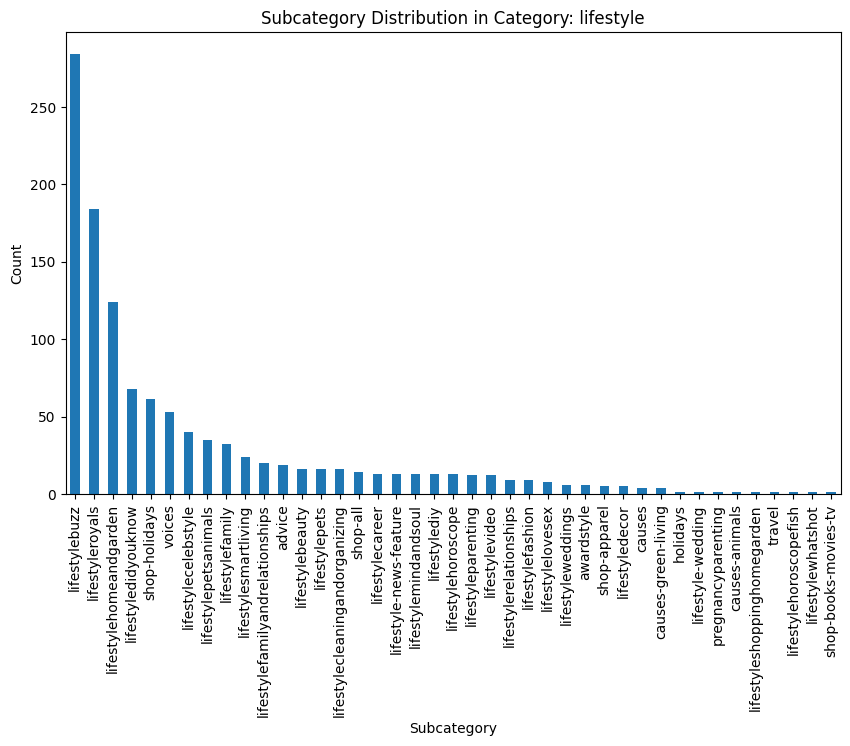

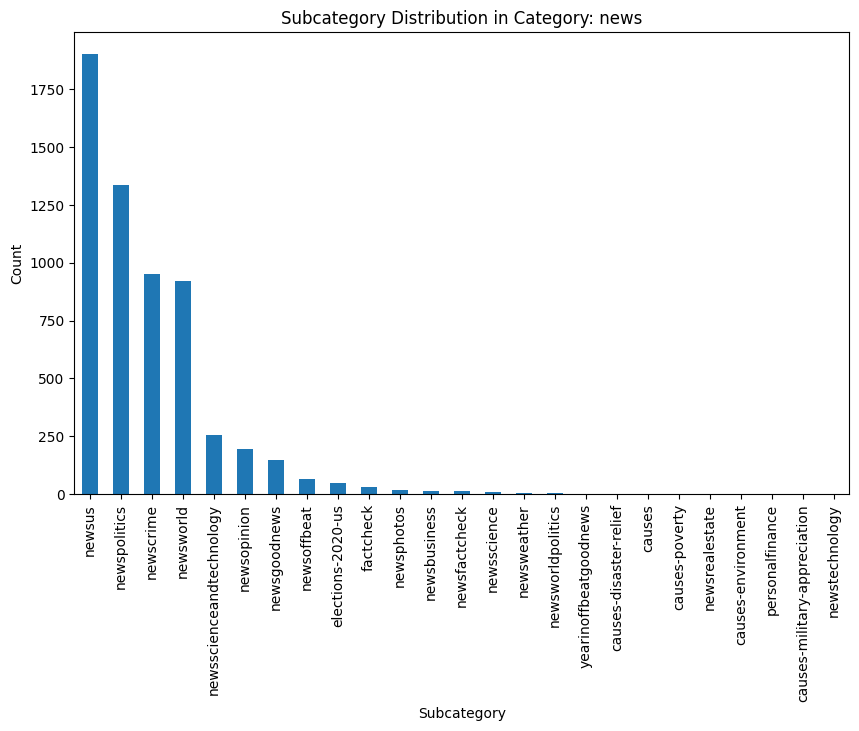

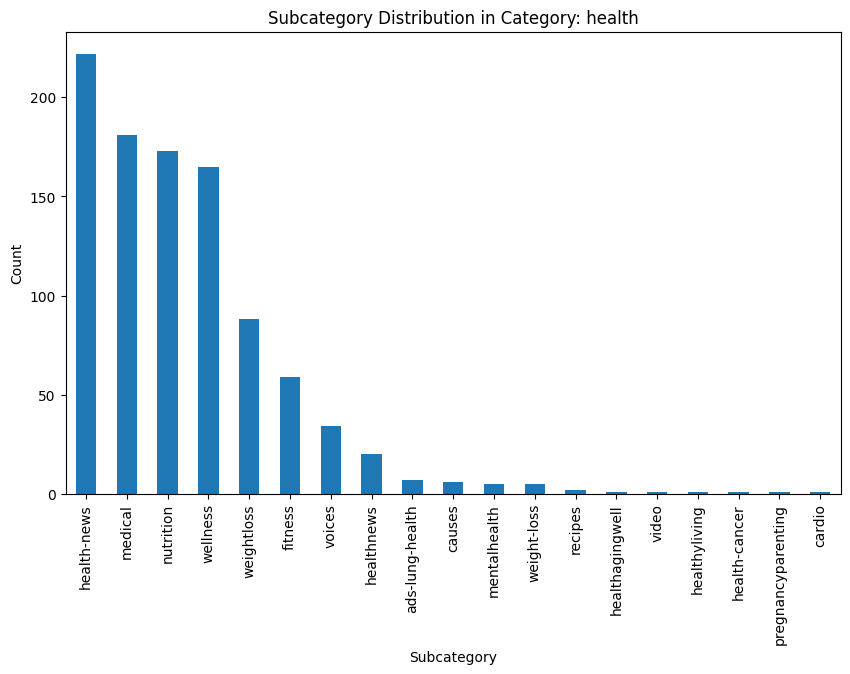

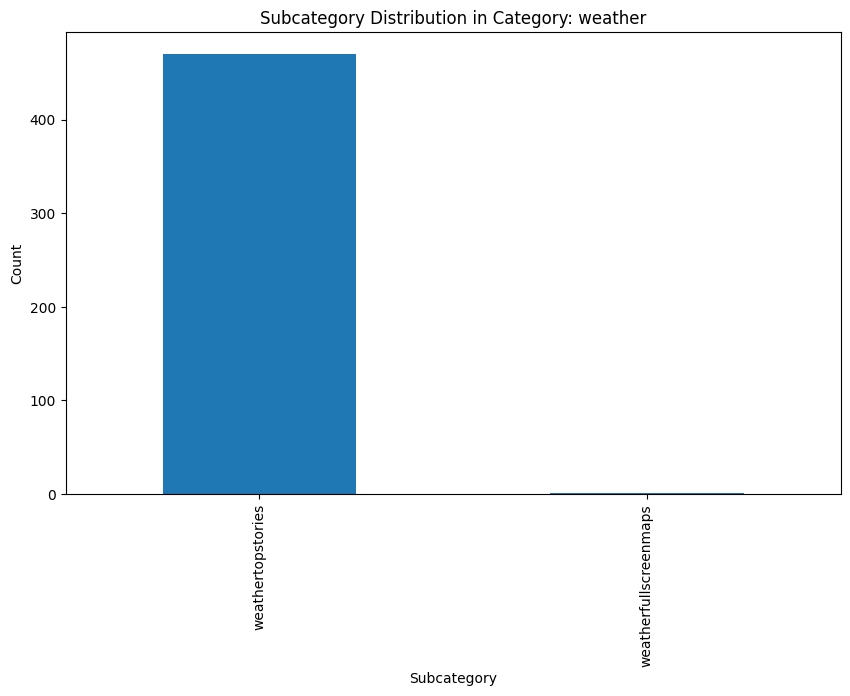

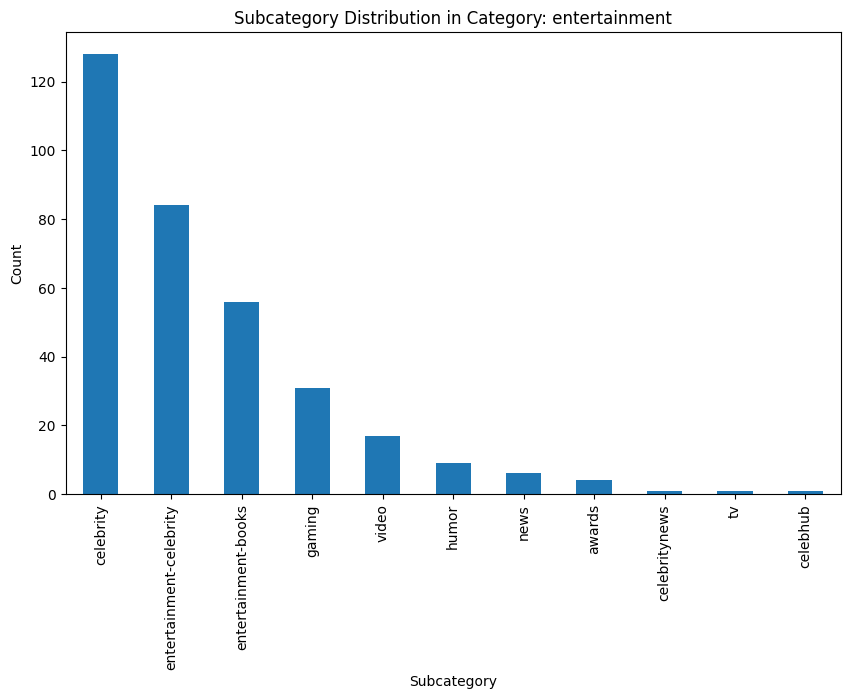

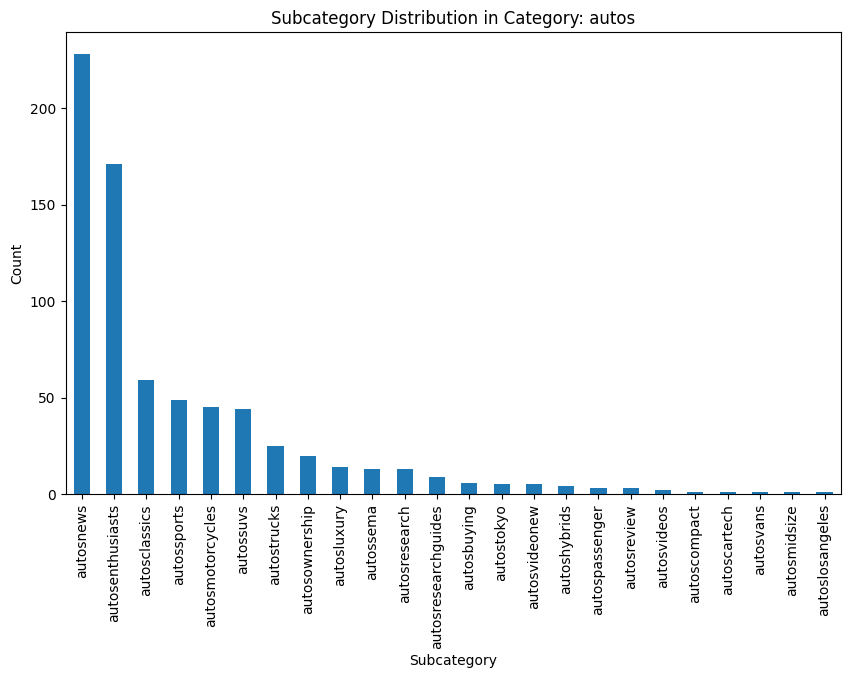

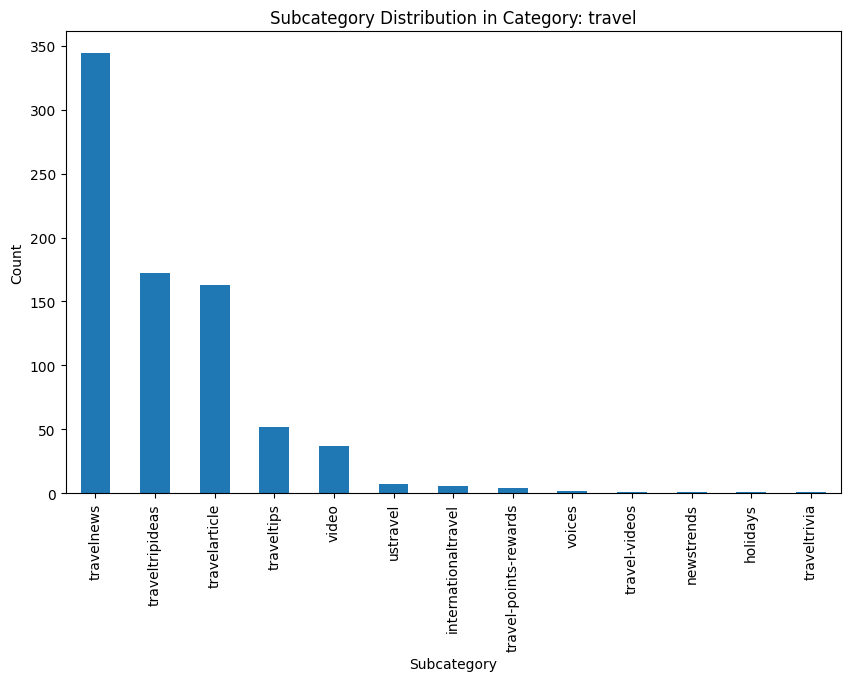

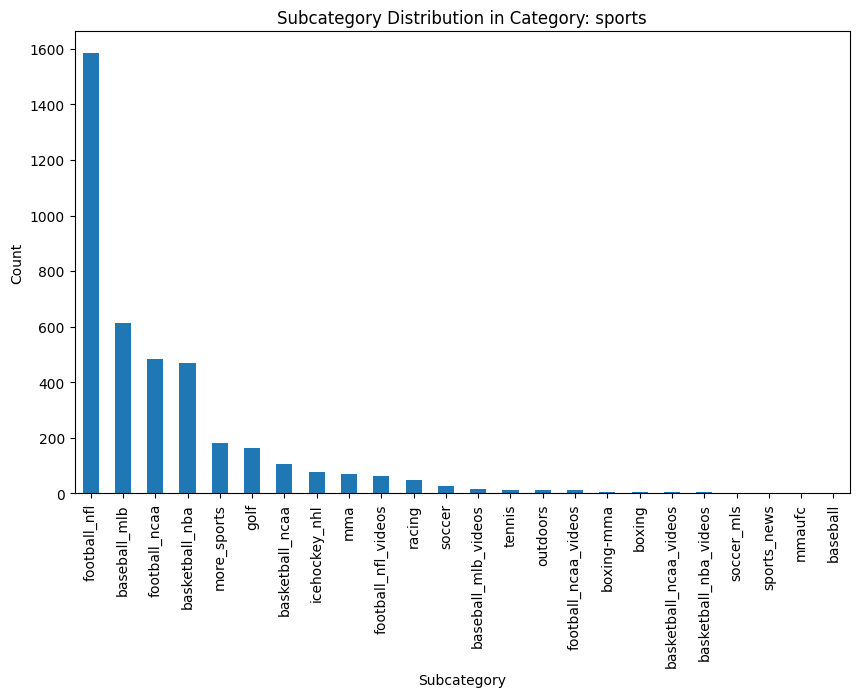

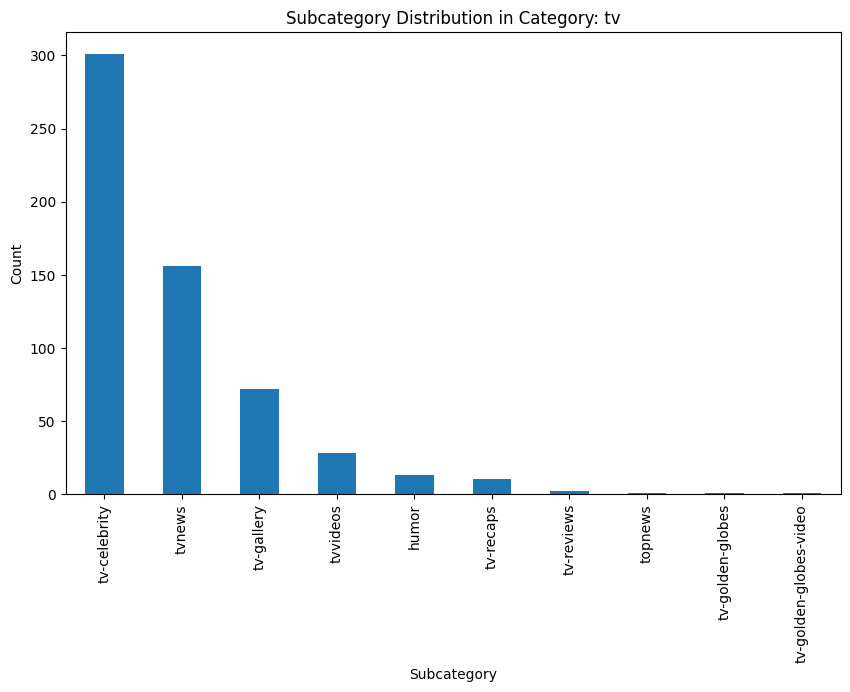

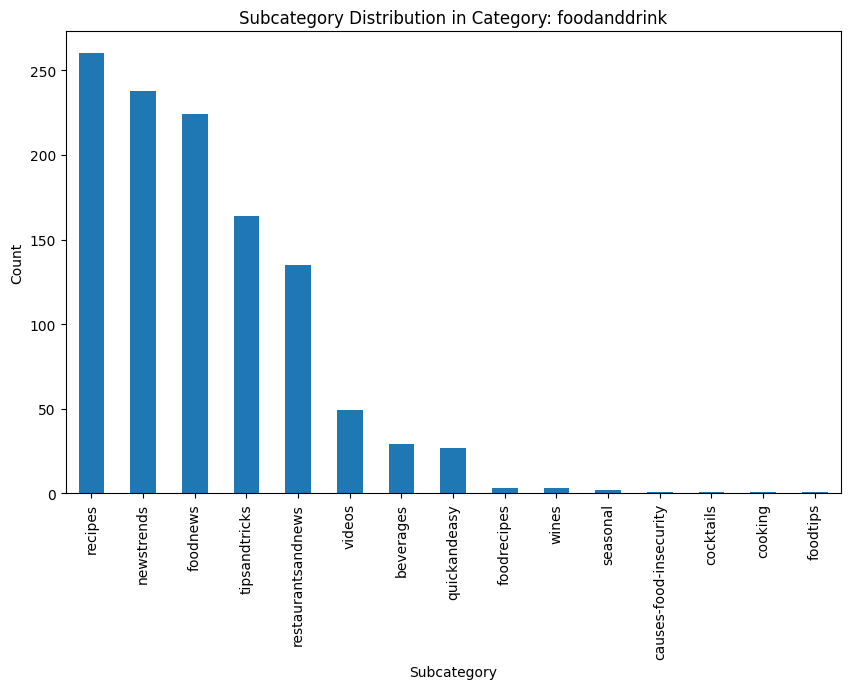

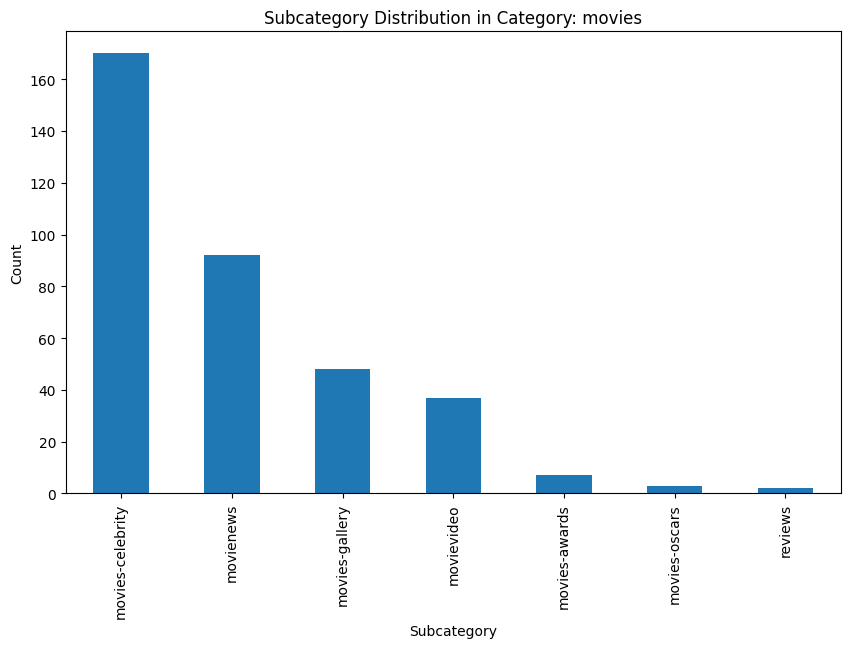

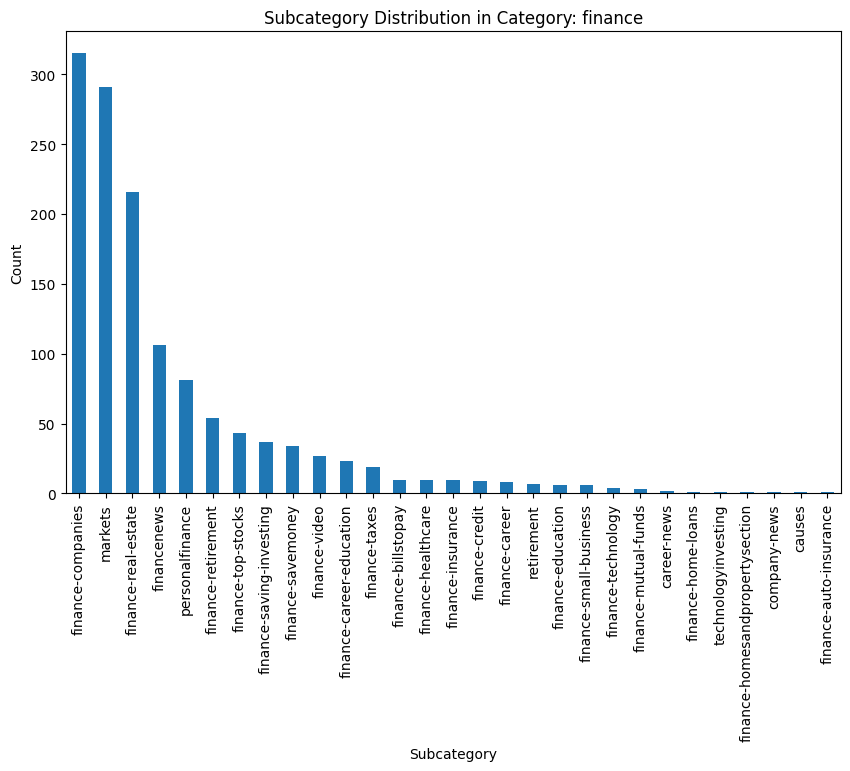

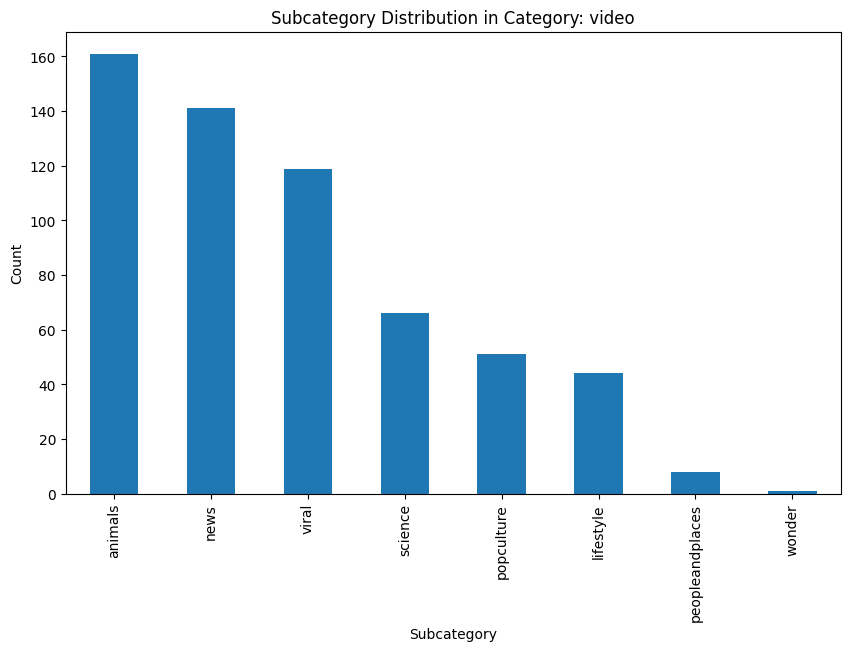

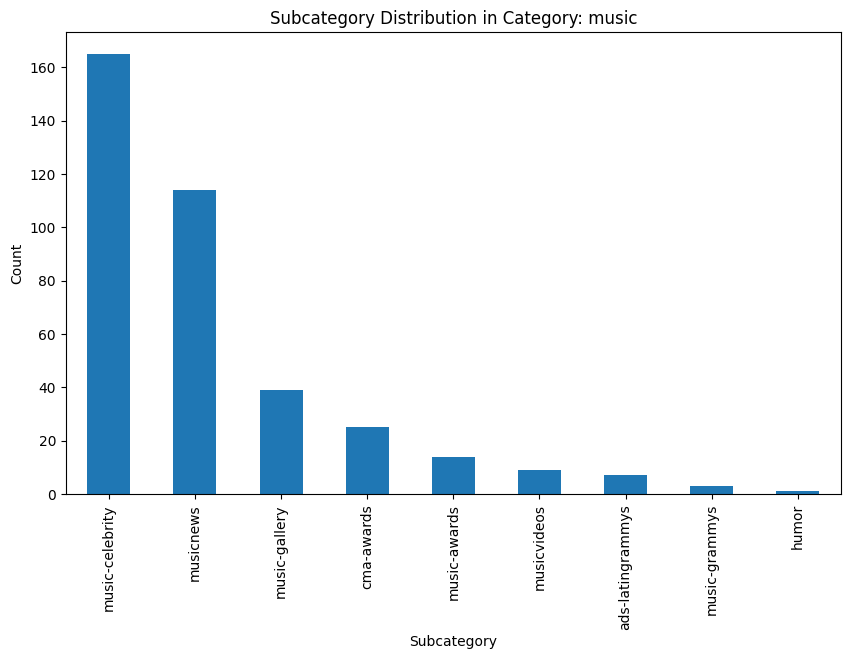

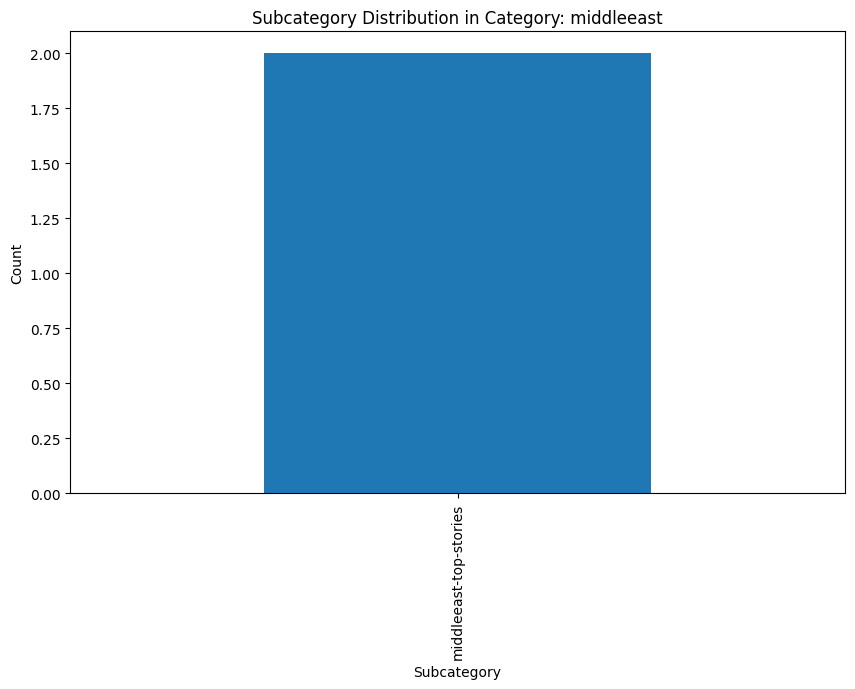

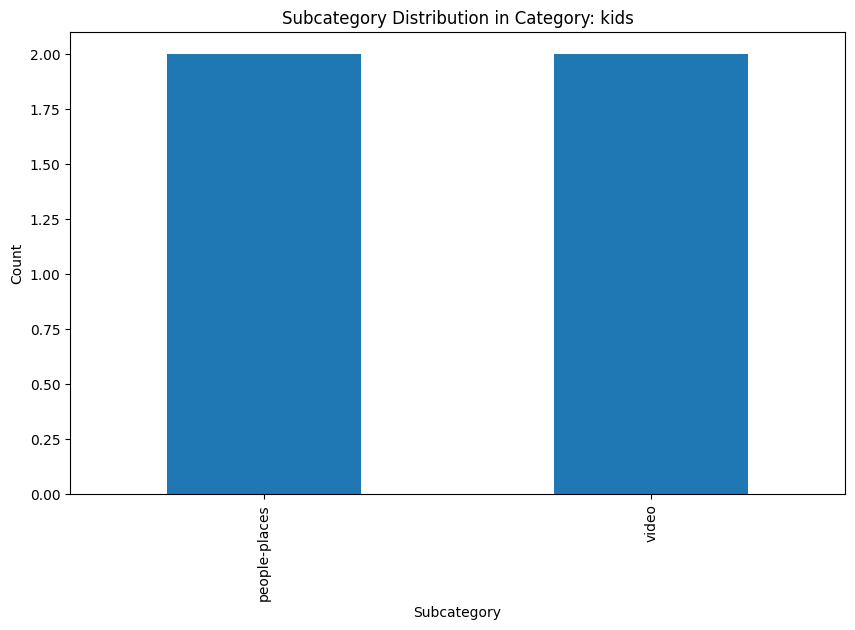

In [213]:
import matplotlib.pyplot as plt

# Get unique categories from the DataFrame
categories = df_news['category'].unique()

# Define colors for the bars

# Create a bar graph for each category
for category in categories:
    subcategory_counts = df_news[df_news['category'] == category]['subcategory'].value_counts()
    
    # Plot the bar graph
    plt.figure(figsize=(10, 6))
    subcategory_counts.plot(kind='bar')
    plt.title(f'Subcategory Distribution in Category: {category}')
    plt.xlabel('Subcategory')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.savefig(f'./figures/recommendations/subcategory_{category}.png', bbox_inches='tight')

    plt.show()


# Check overlap between recommended articles and user history

In [268]:
user_id = 'U41827'
historical_clicks = df_behavior[df_behavior['user_id'] == user_id]['user_click_history'].iloc[0].split()
historical_clicks

['N15366',
 'N12202',
 'N27489',
 'N19773',
 'N21134',
 'N18191',
 'N6863',
 'N11838',
 'N22940',
 'N11838',
 'N7373',
 'N14672',
 'N20561',
 'N16234',
 'N12038',
 'N25392',
 'N26417',
 'N19248',
 'N7214',
 'N20951',
 'N27993',
 'N21',
 'N16998',
 'N20854',
 'N15119',
 'N12563',
 'N2694',
 'N26376',
 'N6178',
 'N11315',
 'N695',
 'N17348',
 'N16106',
 'N18994',
 'N16620',
 'N19892',
 'N3941',
 'N13178',
 'N17369']

In [58]:
df_behavior

,impression_id,user_id,impression_time,user_click_history,impression_news,clicked_categories
0,1,U41827,11/15/2019 2:41:03 PM,N15366 N12202 N27489 N19773 N21134 N18191 N686...,N23699-0 N21291-0 N1901-0 N27292-0 N17443-0 N1...,"[sports, sports, news, news, news, news, news,..."
1,2,U61881,11/15/2019 10:31:42 AM,N16469 N4202 N4202 N21816 N12992 N24242 N7366 ...,N26916-0 N4641-0 N25522-0 N14893-0 N19035-0 N3...,"[news, news, news, news, news, sports, news, t..."
2,3,U54180,11/15/2019 5:36:17 AM,N22427 N16386 N24242 N4385 N14672 N12242 N1852...,N13528-0 N27689-0 N10879-0 N11662-0 N14409-0 N...,"[news, sports, sports, sports, sports, enterta..."
3,4,U41164,11/15/2019 9:13:44 AM,N13065 N5748 N12658 N276 N7395 N16010 N13761 N...,N20150-0 N1807-1 N26916-0 N28138-0 N9576-0 N19...,"[sports, sports, sports, news, news, movies, s..."
4,5,U8588,11/15/2019 5:39:04 AM,N6629 N4958 N10917 N27079 N828,N21325-0 N5982-0 N19737-1 N9576-0 N20150-0 N25...,"[movies, tv, finance, lifestyle, video]"
...,...,...,...,...,...,...
7533,7534,U23841,11/15/2019 9:07:10 AM,N14405 N417 N16730 N23945 N15405 N25316 N13678...,N26256-0 N28117-0 N2718-0 N16798-0 N27689-0 N6...,"[movies, foodanddrink, sports, sports, tv, lif..."
7534,7535,U28014,11/15/2019 2:06:47 PM,N1053 N26708 N26570 N12924 N24356 N11647 N2759...,N26670-0 N12794-0 N3390-0 N17443-0 N27292-0 N2...,"[finance, music, news, news, video, sports, tv..."
7535,7536,U89684,11/15/2019 9:07:58 AM,N25457 N27206 N23987 N26009 N545 N2573 N22908 ...,N17443-0 N16798-0 N24553-0 N26096-0 N15927-0 N...,"[tv, lifestyle, finance, news, news, travel, l..."
7536,7537,U92611,11/15/2019 11:52:28 AM,N107 N15735 N11987 N16777 N20030 N26557 N8238 ...,N14850-0 N26647-0 N272-0 N22751-0 N21398-0 N26...,"[news, news, news, news, finance, news, news, ..."


In [103]:
category_lookup = df_news.set_index('newsid')['category'].to_dict()
subcategory_lookup = df_news.set_index('newsid')['subcategory'].to_dict()

def extract_categories_from_history(row, category_lookup):
    news_ids = str(row['user_click_history']).split()
    categories = [category_lookup.get(news_id) for news_id in news_ids if news_id in category_lookup]
    return categories

df_behavior['clicked_categories'] = df_behavior.apply(extract_categories_from_history, axis=1, args=(category_lookup,))
df_behavior['clicked_subcategories'] =df_behavior.apply(extract_categories_from_history, axis=1, args=(subcategory_lookup,))

In [117]:
parsed_results_categories = {user_id: [category_lookup.get(news_id) for news_id in news_list if news_id in category_lookup] 
                             for user_id, news_list in parsed_results.items()}

parsed_results_subcategories = {user_id: [subcategory_lookup.get(news_id) for news_id in news_list if news_id in subcategory_lookup] 
                             for user_id, news_list in parsed_results.items()}

In [152]:
def calculate_percentage_overlap(impression_id, df_behavior, parsed_results_categories, key='clicked_categories'):
    user_history_categories = set(df_behavior[df_behavior['impression_id'] == impression_id][key].iloc[0])
    recommended_categories = set(parsed_results_categories.get(str(impression_id), []))
    overlap = user_history_categories.intersection(recommended_categories)
    total_unique_categories = user_history_categories.union(recommended_categories)
    if total_unique_categories:
        return len(overlap) / len(total_unique_categories) * 100, user_history_categories, recommended_categories
    else:
        return 0

# Example for a single user
percentage_overlap = calculate_percentage_overlap(1, df_behavior, parsed_results_categories)
subcategory_po = calculate_percentage_overlap(1, df_behavior, parsed_results_subcategories, key = 'clicked_subcategories')
subcategory_po

(41.66666666666667,
 {'basketball_nba',
  'factcheck',
  'football_ncaa',
  'football_nfl',
  'lifestylebuzz',
  'markets',
  'more_sports',
  'newscrime',
  'newspolitics',
  'newsus',
  'newsworld',
  'science',
  'tv-celebrity'},
 {'autosenthusiasts',
  'basketball_nba',
  'celebrity',
  'finance-companies',
  'finance-real-estate',
  'football_nfl',
  'lifestylebuzz',
  'markets',
  'more_sports',
  'movienews',
  'movies-gallery',
  'musicnews',
  'newscrime',
  'newspolitics',
  'newsus',
  'newsworld',
  'recipes',
  'shop-holidays',
  'tv-celebrity',
  'voices',
  'weathertopstories'})

In [167]:
total_overlaps = {}
for i in range(len(df_behavior)):    
    po, _, _ = calculate_percentage_overlap(i+1, df_behavior, parsed_results_categories)
    total_overlaps[i+1] = po

Text(0, 0.5, 'Percent Overlap')

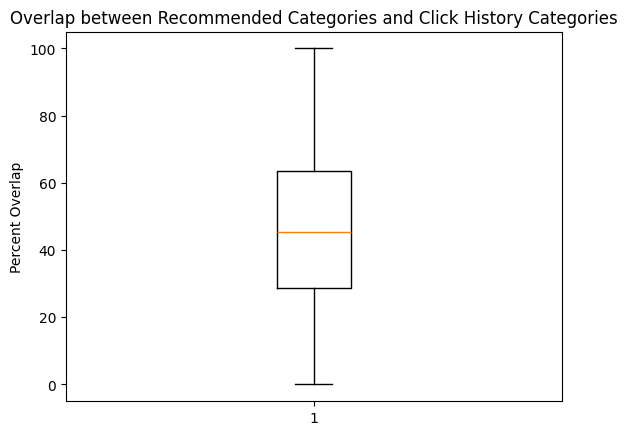

In [101]:

# Creating the boxplot
plt.boxplot(total_overlaps)

# Adding title and labels (optional)
plt.title("Overlap between Recommended Categories and Click History Categories")
plt.ylabel("Percent Overlap")


In [137]:
total_overlaps_sc = {}
for i in range(len(df_behavior)):    
    po, _, _ = calculate_percentage_overlap(i+1, df_behavior, parsed_results_subcategories,'clicked_subcategories')
    total_overlaps_sc[i+1] = po


Text(0.5, 0, 'Total Impressions')

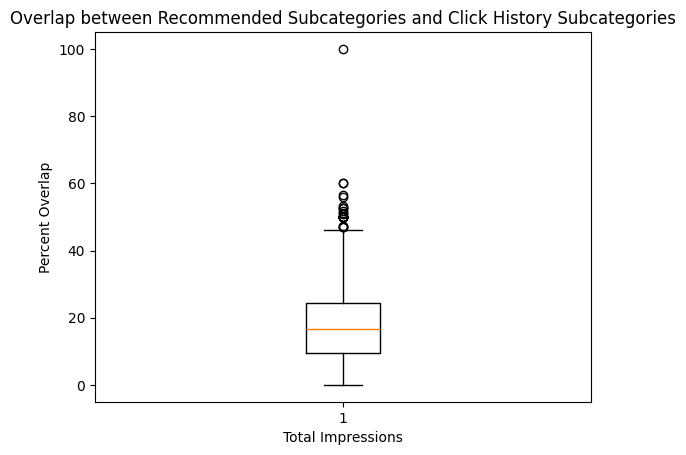

In [142]:

# Creating the boxplot
plt.boxplot(total_overlaps_sc.values())

# Adding title and labels (optional)
plt.title("Overlap between Recommended Subcategories and Click History Subcategories")
plt.ylabel("Percent Overlap")
plt.xlabel('Total Impressions')


In [145]:
keys_with_value_1000 = [key for key, value in total_overlaps_sc.items() if value == 100]
keys_with_value_1000

[4779]

In [153]:
subcategory_po, user_history, recommended = calculate_percentage_overlap(4779, df_behavior, parsed_results_subcategories, key = 'clicked_subcategories')
subcategory_po

100.0

In [155]:
user_history

{'newsus', 'shop-holidays'}

In [156]:
recommended

{'newsus', 'shop-holidays'}

In [172]:
keys_with_value_zero = [key for key, value in total_overlaps_sc.items() if value == 0]

count = 0
for i in keys_with_value_zero:
    subcategory_po, user_history, recommended = calculate_percentage_overlap(i, df_behavior, parsed_results_subcategories, key = 'clicked_subcategories')
    print("Percentage Overlap", subcategory_po, "User History", user_history)
    print("Recommended News", recommended)
    print()
    
    count += 1
    if count > 10:
        break

Percentage Overlap 0.0 User History {'lifestylebuzz', 'movies-celebrity', 'tv-celebrity', 'finance-companies', 'animals'}
Recommended News {'restaurantsandnews', 'autosenthusiasts', 'football_nfl', 'shop-holidays', 'newsus', 'science', 'weathertopstories', 'lifestyleroyals'}

Percentage Overlap 0.0 User History set()
Recommended News {'newspolitics', 'autosenthusiasts', 'football_nfl', 'science', 'shop-holidays', 'musicnews', 'newsus', 'markets', 'restaurantsandnews', 'weathertopstories', 'lifestyleroyals', 'basketball_nba'}

Percentage Overlap 0.0 User History {'newsus', 'lifestyle', 'movies-celebrity', 'newscrime'}
Recommended News {'musicnews', 'shop-holidays'}

Percentage Overlap 0.0 User History {'newspolitics', 'lifestylebuzz', 'lifestylehomeandgarden', 'newsus', 'tvnews'}
Recommended News {'newscrime', 'basketball_nba'}

Percentage Overlap 0.0 User History set()
Recommended News {'newsus', 'baseball_mlb', 'viral', 'shop-holidays'}

Percentage Overlap 0.0 User History {'lifestyle

In [ ]:
# Check top categories recommended per impressoin